In [27]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from math import floor, ceil # for rounding up and down
from scipy.stats import pearsonr
from sklearn import datasets
import pandas as pd
import math
from typing import Dict, Tuple, List
import copy
from random import randint

def Get_Class_Label_Of_Object(x):
    return x[len(x)-1]

def Distance(x, y):
    if len(x) != len(y):
        return -1
    
    sum = 0
    for i in range(len(x)):
        sum += (x[i]-y[i])*(x[i]-y[i])
        
    return sum

In [2]:
def PrepareData():
    all_data = np.loadtxt(open("./wine_data.csv","r"), delimiter = ",", skiprows = 0, dtype = np.float64)

    print (all_data)
    
    # load class labels from column 1
    y_wine = all_data[:,0]
    #print (y_wine)
    # conversion of the class labels to integer-type array
    y_wine = y_wine.astype(np.int64, copy = False)

    # load the 14 features
    X_wine = all_data[:,1:]
    
    data = all_data[:, 6:8]   #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 6:9    
    
    from scipy.stats import pearsonr

    x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
    y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5

    plt.figure(2, figsize = (16, 12))
    plt.clf()

    # Plot the training points
    plt.scatter(data[:, 0], data[:, 1], c = y_wine, cmap = plt.cm.Set1, edgecolor = 'k')
    plt.xlabel('Flavanoids')
    plt.ylabel('Nonflavanoid phenols')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()

    uniq = [1 for x in range(len(data))]
    
    cnt_of_uniq = 0
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            if data[i, 0] == data[j, 0] and data[i, 1] == data[j, 1]:
                uniq[j] = 0
   
    for i in range(len(data)):
        if uniq[i] == 1:
            cnt_of_uniq += 1
            
    w, h = 3, cnt_of_uniq
    m = [[0 for x in range(w)] for y in range(h)] 
          
    cur_cnt = 0
    for i in range(len(data)):
        if uniq[i] == 1:
            for j in range(2):
                m[cur_cnt][j] = data[i, j]
            m[cur_cnt][2] = y_wine[i]-1
            cur_cnt += 1
    
    data = m
    return data

data = PrepareData()



def Prepare_Iris_Data():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn import datasets
    from sklearn.decomposition import PCA

    # import some data to play with
    iris = datasets.load_iris()
    X = iris.data[:, 2:4]  # we only take the first two features.
    y = iris.target

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    plt.figure(2, figsize = (16, 12))
    plt.clf()

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Set1, edgecolor = 'k')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    uniq = [1 for x in range(len(X))]
    
    cnt_of_uniq = 0
    for i in range(len(X)):
        for j in range(i+1,len(X)):
            if X[i, 0] == X[j, 0] and X[i, 1] == X[j, 1]:
                uniq[j] = 0
   
    for i in range(len(X)):
        if uniq[i] == 1:
            cnt_of_uniq += 1
            
    w, h = 3, cnt_of_uniq
    m = [[0 for x in range(w)] for y in range(h)] 
          
    cur_cnt = 0
    for i in range(150):
        if uniq[i] == 1:
            for j in range(2):
                m[cur_cnt][j] = X[i, j]
            m[cur_cnt][2] = y[i]
            cur_cnt += 1
    
    data = m
    return data
    
iris_data = Prepare_Iris_Data()

In [77]:
class FRiS_STOLP:
    EPS = 1E-7
    
    def Get_Nearest_Neighbour(self, x, Omega):
        dist = [0]*len(Omega)

        for i in range(len(Omega)):
            dist[i] = Distance(x[0:len(x)-1], Omega[i][0:len(x)-1])

        min_dist = min(dist)

        for i in range(len(Omega)):
            if dist[i] + self.EPS > min_dist and dist[i] - self.EPS < min_dist:
                return Omega[i]

    def FindEtalon(self, X, Omega, Xl, defence_to_tolerance_ratio):
        label = Get_Class_Label_Of_Object(X[0])
        Efficiency = [0]*len(X)
        
        Tolerance_denom = 0
        for item in Xl: 
            if Get_Class_Label_Of_Object(item) != label:
                Tolerance_denom += 1
                
        if Tolerance_denom == 0:
            Tolerance_denom = 1
               
        
        NN_enemy_etalon_For_Defence = [list() for t in range(len(X))]
        
        for p in range(len(X)):
            item = X[p]
            if Get_Class_Label_Of_Object(item) == label:
                NN_enemy_etalon_For_Defence[p] = self.Get_Nearest_Neighbour(item, Omega)
        
        
        NN_enemy_etalon_For_Tolerance = [list() for t in range(len(Xl))]
        
        for p in range(len(Xl)):
            item = Xl[p]
            if Get_Class_Label_Of_Object(item) != label:
                NN_enemy_etalon_For_Tolerance[p] = self.Get_Nearest_Neighbour(item, Omega)
        
        for i in range(len(X)):
            x = X[i]
            sum_of_defence = 0
            
            for j in range(len(X)):
                item = X[j]
                if item != x and Get_Class_Label_Of_Object(item) == label:
                    S = self.FRiS(NN_enemy_etalon_For_Defence[j], item, x)
                    sum_of_defence += S

            Defence = sum_of_defence / (len(X)-1)

            Tolerance_sum = 0
            
            NN_enemy_etalon = []
            NN_enemy_etalon = [list() for t in range(len(Xl))]
          
            for j in range(len(Xl)): 
                item = Xl[j]
                if Get_Class_Label_Of_Object(item) != label:
                    S = self.FRiS(x, item, NN_enemy_etalon_For_Tolerance[j])
                    Tolerance_sum += S

            Tolerance = Tolerance_sum / Tolerance_denom

            Efficiency[i] = defence_to_tolerance_ratio * Defence + (1.0 - defence_to_tolerance_ratio) * Tolerance

        max_Efficiency = max(Efficiency)

        for i in range(len(X)):
            if Efficiency[i] + self.EPS > max_Efficiency and Efficiency[i] - self.EPS < max_Efficiency:
                return X[i]


    def Get_Objects_From_Ith_Class(self, X, class_label):
        cnt = 0

        for i in range(len(X)):
            obj = X[i]

            if Get_Class_Label_Of_Object(obj) == class_label:
                cnt += 1

        w, h = 4, cnt
        res = [[0 for x in range(w)] for y in range(h)] 

        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) == class_label:
                res[cnt] = obj
                cnt += 1

        return res

    # --------------------------------------------------------------

    def Get_Enemies_Of_Ith_Class(self, X, class_label):
        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) != class_label:
                cnt += 1

        w, h = 4, cnt
        res = [[0 for x in range(w)] for y in range(h)] 

        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) != class_label:
                res[cnt] = obj
                cnt += 1

        return res

    # --------------------------------------------------------------

    def Truncate_Set(self, X, Y):
        res = []
        for i in range(len(X)):
            is_exist = False

            for j in range(len(Y)):
                if X[i] == Y[j]:
                    is_exist = True
                    break

            if is_exist == False:
                res[len(res):]  = [X[i]]

        return res

    # --------------------------------------------------------------

    
    def FRiS(self, a, x, c):
        S_nom = math.sqrt(Distance(a[0:len(x)-1], x[0:len(x)-1])) - math.sqrt(Distance(x[0:len(x)-1], c[0:len(x)-1]))
        S_denom = math.sqrt(Distance(a[0:len(x)-1], x[0:len(x)-1])) + math.sqrt(Distance(x[0:len(x)-1], c[0:len(x)-1]))
        S = S_nom / S_denom
        return S    
    
    def Construct_A_Set_Of_Correctly_Classified_Objects(self, Xl, Etalons):
        res = []
        
        for i in range(len(Xl)):
            x = Xl[i]
            label_of_cur_class = Get_Class_Label_Of_Object(x)

            Enemies_Etalons = copy.deepcopy(Etalons)
            del Enemies_Etalons[label_of_cur_class]
            Enemies_Etalons = self.Merge_Elements(Enemies_Etalons)
            
            nearest_neighbour_friend = self.Get_Nearest_Neighbour(x, Etalons[label_of_cur_class])
            nearest_neighbour_enemy = self.Get_Nearest_Neighbour(x, Enemies_Etalons)
            
            S = self.FRiS(nearest_neighbour_enemy, x, nearest_neighbour_friend)
            
            if S > 0:
                res[len(res):] = [x]
                
        return res
    # --------------------------------------------------------------  

    def Get_Number_Of_Classes_In_Dataset(self, Xl):
        len_of_obj = len(Xl[0])
        
        labels = set()
        for obj in Xl:
            cur_label = obj[len_of_obj-1]
            labels.add(cur_label)
    
        return len(labels)
        
    def Merge_Elements(self, lst):
        res = []
        for i in range(len(lst)):
            res += lst[i]
            
        return res
    
    def Classify_By_1NN(self, u, Etalons):
        number_of_classes = self.Get_Number_Of_Classes_In_Dataset(Etalons)
        nn = self.Get_Nearest_Neighbour(u, Etalons)
        return Get_Class_Label_Of_Object(nn)
        
    def Get_Etalons(self, Xl):
        number_of_classes = self.Get_Number_Of_Classes_In_Dataset(Xl)
        
        Etalons = [list() for i in range(number_of_classes)]

        for i in range(3):    
            Xy = self.Get_Objects_From_Ith_Class(Xl, i)
            X_enemies = self.Get_Enemies_Of_Ith_Class(Xl, i)
            
            Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, X_enemies, Xl, 0.5)]
            
        print (Etalons)
            
        for i in range(3):
            Xy = self.Get_Objects_From_Ith_Class(Xl, i)

            Enemies_Etalons = copy.deepcopy(Etalons)
          
            del Enemies_Etalons[i]
            Enemies_Etalons = self.Merge_Elements(Enemies_Etalons)
            
            Etalons[i] = []
            Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, Enemies_Etalons, Xl, 0.5)]
            
     
        while len(Xl) > 0:
            U = self.Construct_A_Set_Of_Correctly_Classified_Objects(Xl, Etalons)
         
            Xl = self.Truncate_Set(Xl, U)

            for i in range(3):
                Xy = self.Get_Objects_From_Ith_Class(Xl, i)

                if len(Xy) == 0: 
                    continue

                Enemies_Etalons = copy.deepcopy(Etalons)
                del Enemies_Etalons[i]
                Enemies_Etalons = self.Merge_Elements(Enemies_Etalons)
                
                if len(Xy) == 1:
                    obj = Xy[0]
                    Etalons[i][len(Etalons[i]):] = [obj]
                else:
                    Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, Enemies_Etalons, Xl, 0.5)]

        return Etalons
    
    def FRiS_Support_Classify(self, u, xl, k, draw_plot_if_two_dimentional):
        number_of_classes = self.Get_Number_Of_Classes_In_Dataset(xl)

        nn = [list() for t in range(number_of_classes)]

        for i in range(number_of_classes):
            Xy = self.Get_Objects_From_Ith_Class(xl, i)
            nn[i] = self.Get_Nearest_Neighbour(u, Xy)

       # print (nn)
        
        candidates_for_supporting = [list() for t in range(number_of_classes)]
        for cur_class in range(number_of_classes):
            candidates_for_supporting[cur_class] = self.Get_Objects_From_Ith_Class(xl, cur_class)
            candidates_for_supporting[cur_class].remove(nn[cur_class])
        
        supporting_list = [list() for t in range(number_of_classes)]
        
        for cur_class in range(number_of_classes):
            for it in range(k-1):
                supporting_element = fris.Get_Nearest_Neighbour(nn[cur_class], candidates_for_supporting[cur_class])
                candidates_for_supporting[cur_class].remove(supporting_element)
                supporting_list[cur_class].append(supporting_element)
        
        
        sum_of_fris = [0 for t in range(number_of_classes)]
    
        for cur_class in range(number_of_classes):
            for i in range(len(supporting_list[cur_class])):
                sum_of_fris[cur_class] += self.FRiS(supporting_list[cur_class][i], nn[cur_class], u)
            
            sum_of_fris[cur_class] /= len(supporting_list[cur_class])
    
        #print (sum_of_fris)
            
        label = sum_of_fris.index(max(sum_of_fris))
        
        #---------------------------------------------------------
        if len(u)-1 == 2 and draw_plot_if_two_dimentional == True:           
            cur_col = 'green'
            
            if label == 0:
                cur_col = 'red'
            if label == 1:
                cur_col = 'blue'
            
            plt.scatter([u[0]], [u[1]], c = cur_col, s = 25)
            
            x1_coord = []
            x2_coord = []
            y = []
            for i in range(len(xl)):
                x1_coord.append(xl[i][0])
                x2_coord.append(xl[i][1])
                y.append(xl[i][2])

            plt.scatter(x1_coord, x2_coord, c = y, cmap = plt.cm.Set1, s = 25)
            
        #---------------------------------------------------------
        #if label == 1:
        #    print (label)
        
        return label

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


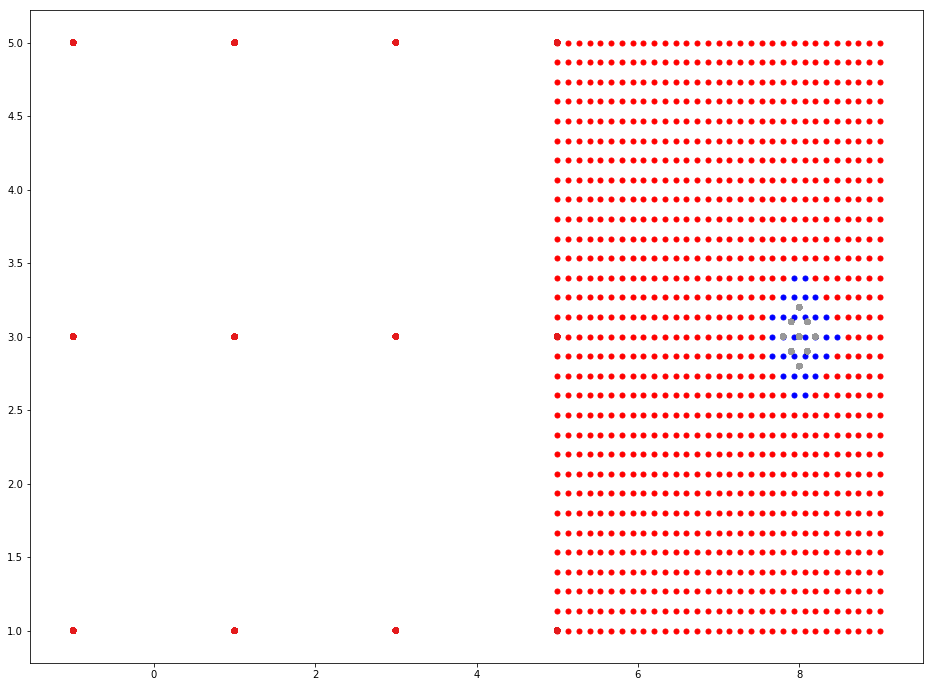

In [78]:
xl_0 = [[-1, 1, 0], [-1, 3, 0], [-1, 5, 0], [1, 1, 0], [1, 3, 0], [1, 5, 0], [3, 1, 0], [3, 3, 0], [3, 5, 0], [5, 1, 0], [5, 3, 0], [5, 5, 0]]
xl_1 = [[8, 3, 1], [7.8, 3, 1], [8.2, 3, 1], [8, 3.2, 1], [8, 2.8, 1], [7.9, 2.9, 1], [7.9, 3.1, 1], [8.1, 2.9, 1], [8.1, 3.1, 1]]

xl = xl_0 + xl_1

fris = FRiS_STOLP()

x_min = 5
y_min = 1

x_max = 9
y_max = 5

N = 30
M = 30

plt.figure(2, figsize = (16, 12))

dx = (x_max-x_min)/N
dy = (y_max-y_min)/M

for i in range(N+1):
    x = x_min + i * dx
    for j in range(M+1):
        y = y_min + j * dy
        u = [x, y, -1]
        fris.FRiS_Support_Classify(u = u, xl = xl, k = 5, draw_plot_if_two_dimentional = True)

plt.show()

[[[3.0, 3.1699999999999999, 0]], [], []]
[[[3.0, 3.1699999999999999, 0]], [[1.95, 1.6899999999999999, 1]], []]
[[[3.0, 3.1699999999999999, 0]], [[1.95, 1.6899999999999999, 1]], [[1.6200000000000001, 0.66000000000000003, 2]]]


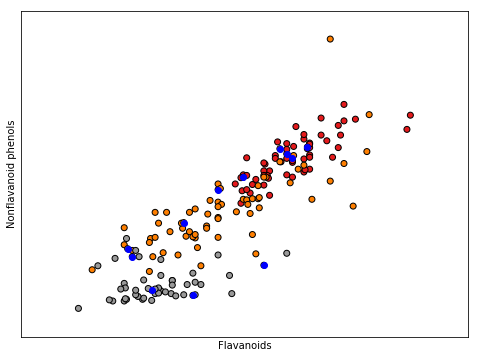

In [5]:
fris = FRiS_STOLP()
Etalons = fris.Get_Etalons(data)

all_data = np.loadtxt(open("./wine_data.csv","r"), delimiter = ",", skiprows = 0, dtype = np.float64)


# load class labels from column 1
y_wine = all_data[:,0]
#print (y_wine)
# conversion of the class labels to integer-type array
y_wine = y_wine.astype(np.int64, copy = False)

# load the 14 features
X_wine = all_data[:,1:]

data = all_data[:, 6:8]   #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 6:9    

from scipy.stats import pearsonr

x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5

plt.figure(2, figsize = (8, 6))
plt.clf()

# Plot the training points
plt.scatter(data[:, 0], data[:, 1], c = y_wine, cmap = plt.cm.Set1, edgecolor = 'k')
plt.xlabel('Flavanoids')
plt.ylabel('Nonflavanoid phenols')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

x_coord = []
y_coord = []
labels = []

Etalons = fris.Merge_Elements(Etalons)

for i in range(len(Etalons)):
    x_coord.append(Etalons[i][0])
    
for i in range(len(Etalons)):
    y_coord.append(Etalons[i][1])

#plt.plot(iris_data[119][0], iris_data[119][1], 'ro', color = 'g')
plt.plot(x_coord, y_coord, 'ro', color = 'b')

plt.show()

[[[1.5, 0.29999999999999999, 0]], [], []]
[[[1.5, 0.29999999999999999, 0]], [[4.4000000000000004, 1.3, 1]], []]
[[[1.5, 0.29999999999999999, 0]], [[4.4000000000000004, 1.3, 1]], [[5.5, 2.1000000000000001, 2]]]


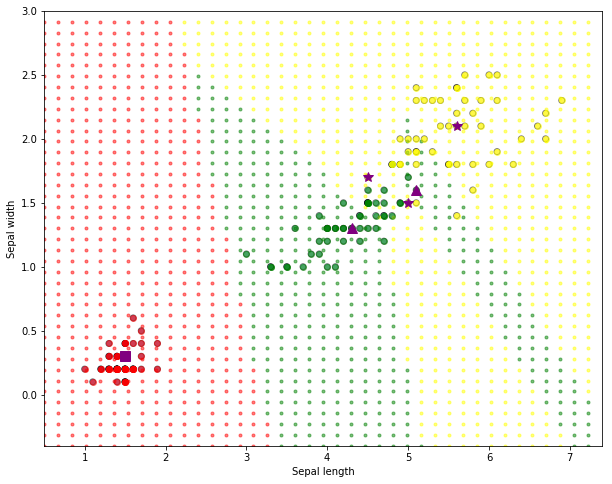

In [6]:
fris_for_iris = FRiS_STOLP()
Etalons_iris = fris_for_iris.Get_Etalons(iris_data)

import matplotlib.pyplot as plt
import matplotlib.colors as matplotcolor
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, 2:4]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize = (10, 8))
plt.clf()


def Create_Classification_Map(x_min, x_max, N, y_min, y_max, M, Etalons):
    dx = (x_max - x_min)/N
    dy = (y_max - y_min)/M
    
    obj_list = [list() for t in range(N*M)]
    
    for i in range(N):
        x = x_min + i * dx
        for j in range(M):
            y = y_min + j * dy
            
            u = [x, y, -1]
            label = fris_for_iris.Classify_By_1NN(u, Etalons)
              
            obj = [x, y, label]    
            obj_list[i*M+j] = obj
            
    return obj_list



    
    

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', alpha = 0.5)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.axis

x_coord = []
y_coord = []
labels = []

Etalons_iris = fris_for_iris.Merge_Elements(Etalons_iris)

classification_map = Create_Classification_Map(x_min, x_max, 40, y_min, y_max, 40, Etalons_iris)

for i in range(len(classification_map)):
    
    obj = classification_map[i]
    label = Get_Class_Label_Of_Object(obj)
        
    cur_col = "white"
    if label == 0:
        cur_col = 'red'
    if label == 1:
        cur_col = 'green'
    if label == 2:
        cur_col = 'yellow'
    
    plt.plot([classification_map[i][0]], [classification_map[i][1]], '.', color = cur_col, fillstyle = 'full', alpha = 0.5)

    
for i in range(len(X)):
    obj = X[i]
    label = y[i]
        
    cur_col = "white"
    if label == 0:
        cur_col = 'red'
    if label == 1:
        cur_col = 'green'
    if label == 2:
        cur_col = 'yellow'
    
    plt.plot([obj[0]], [obj[1]], 'ro', color = cur_col, alpha = 0.5)    


for i in range(len(Etalons_iris)):
    x_coord.append(Etalons_iris[i][0])
    
for i in range(len(Etalons_iris)):
    y_coord.append(Etalons_iris[i][1])

    
for i in range(len(Etalons_iris)):
    shape = 's'
    obj = Etalons_iris[i]
    label = Get_Class_Label_Of_Object(obj)
    
    if label == 0:
        shape = "s"
    if label == 1:
        shape = "^"
    if label == 2:
        shape = "*"
    
    plt.plot([x_coord[i]], [y_coord[i]], shape, color = 'purple', markersize = 10)

plt.show()

In [ ]:
from random import randint
colors = []

for i in range(10):
    colors.append('%06X' % randint(0, 0xFFFFFF))